In [1]:
using KomaMRI, MAT, Plots, WebIO

## Implementation Optimized Shaped Pulse

- Sample A: T1 = 100ms, T2 = 50ms 
- Sample B: T1 = 50ms, T2 = 25ms

### Scanner

In [2]:
sys = Scanner();

**Scanner**

- B0 =     1.5 [T] - main magnetic field
- B1 =    1.0e-5 [T] - maximum RF amplitude
- Gmax =   0.06 [T/m] - maximum gradient
- Smax =   500 [mT/m/ms] - maximum slew-rate
- ADC_Δt = 2.0e-6 [s] - ADC raster time
- seq_Δt = 1.0e-5 [s] - sequence-block raster time
- GR_Δt =  1.0e-5 [s] - gradient raster time
- RF_Δt =  1.0e-6 [s] - RF raster time
- RF_ring_down_T = 2.0e-5 [s] - RF ring down time
- RF_dead_time_T = 0.0001 [s] - RF dead time
- ADC_dead_time_T = 1.0e-5 [s] - ADC dead time

### Sequence

In [3]:
# Importing MATLAB data
file = open("oc_field.mat", "r")

RF_Hz = matread("oc_field.mat")["b1"];
tf_sp = matread("oc_field.mat")["tf_s"];
t_sp = matread("oc_field.mat")["t_s"];
Mmax = matread("oc_field.mat")["Mmax"];
Mmin = matread("oc_field.mat")["Mmin"];

In [4]:
# SEQUENCE
# convert to Tesla
RF_T = RF_Hz/γ;

# 1st block -> RF block
exc = RF(RF_T', tf_sp);

# 2nd block -> ADC block
nADC = 1 ;
durADC = 1e-4 ;
#delay = 1e-3 ;
aqc = ADC(nADC, durADC)

# concatenating the two blocks
seq  = Sequence()
seq += exc
seq += aqc

Sequence[ τ = 50.1 ms | blocks: 3 | ADC: 1 | GR: 0 | RF: 1 | DEF: 0 ]

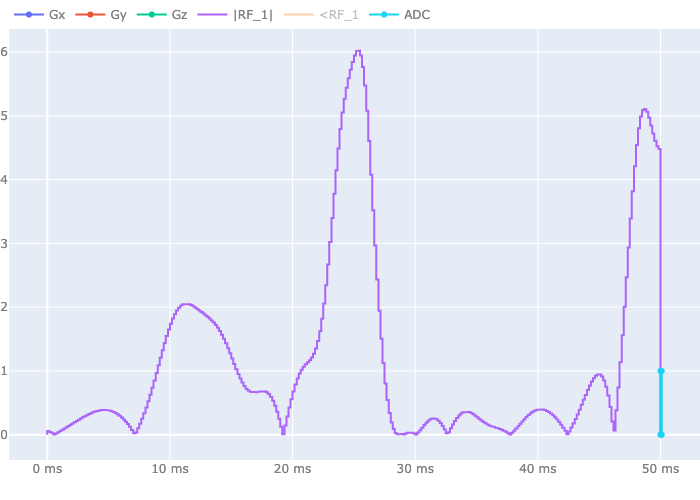

In [5]:
# plot
p1 = plot_seq(seq; slider = false, height = 300, max_rf_samples=Inf)

### Phantom

In [6]:
obj = Phantom{Float64}(name = "spin1", x = [0.], T1 = [50e-3], T2 = [25e-3], Δw = [-2π*100]);

### Simulate

#### Signal

In [7]:
    # SIMULATE #
    signal1 = simulate(obj, seq, sys; simParams=Dict{String,Any}("return_type"=>"state"));

┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/GPUFunctions.jl:29
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1002
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


Progress:  10%|███▉                                     |  ETA: 0:00:40
  simulated_blocks:  2
  rf_blocks:         2





Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
  simulated_blocks:  21
  rf_blocks:         20
  acq_samples:       1


  6.984801 seconds (26.25 M allocations: 1.256 GiB, 4.12% gc time, 98.45% compilation time: 1% of which was recompilation)


#### Signal to magnetization

In [8]:
signal = simulate(obj, seq, sys; simParams=Dict{String,Any}("return_type"=>"state"));
Mx = real(signal.xy)[];
My = imag(signal.xy)[];
Mz = signal.z[];
sig = "max"

  0.055024 seconds (196.67 k allocations: 9.471 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 1002
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


"max"

#### Calculating the fidelity

In [9]:
sig = "min"

# Fidelity
if sig == "max"
    Mxmax = Mmax[2, end]
    Mymax = Mmax[3, end]
    Mzmax = Mmax[4, end]
    fidelity_Mx = round(abs(Mx - Mxmax)*100, digits = 2)
    fidelity_My = round(abs(My - Mymax)*100, digits = 2)
    fidelity_Mz = round(abs(Mz - Mzmax)*100, digits = 2)
else 
    Mxmin = Mmin[2, end]
    Mymin = Mmin[3, end]
    Mzmin = Mmin[4, end]
    fidelity_Mx = round(abs(Mx - Mxmin)*100, digits = 2)
    fidelity_My = round(abs(My - Mymin)*100, digits = 2)
    fidelity_Mz = round(abs(Mz - Mzmin)*100, digits = 2)
end

54.98

In [10]:
println("Fidelity: Mx = $fidelity_Mx%, My = $fidelity_My%, Mz = $fidelity_Mz%")

Fidelity: Mx = 1.21%, My = 21.0%, Mz = 54.98%


### Magnetization dynamics

In [11]:
pieces = 300;
M_sp = zeros(Float64, 3, pieces);
t_koma = zeros(1, pieces);
for i in 1:pieces
    blocks = Int(length(RF_T)/pieces);
    rf = RF_T[1, 1:i*blocks] ;
    t_block = t_sp[1, i*blocks];

    #1st block -> RF block
    exc = RF(rf, t_block);
    
    # 2nd block -> ADC block
    nADC = 1 ;
    durADC = 1e-3 ;
    #delay = 1e-3 ;
    aqc = ADC(nADC, durADC)
    
    # concatenating the two blocks
    seq1  = Sequence();
    seq1 += exc;
    seq1 += aqc;
    #p1 = plot_seq(seq1; slider = false, height = 300, max_rf_samples=Inf)

    # PHANTOM #
    obj1 = Phantom{Float64}(name = "spin1", x = [0.], T1 = [100e-3], T2 = [50e-3], Δw = [2π*10]);

    # SIMULATE #
    signal1 = simulate(obj1, seq1, sys; simParams=Dict{String,Any}("return_type"=>"state"));

    # Magnetization
    M_sp[1, i] = real(signal1.xy)[];
    M_sp[2, i] = imag(signal1.xy)[];
    M_sp[3, i] = signal1.z[];

    # Time
    t_koma[1, i] = t_block;
end

  0.000767 seconds (224 allocations: 12.516 KiB)
  0.000757 seconds (1.18 k allocations: 62.656 KiB)
  0.000720 seconds (2.44 k allocations: 128.766 KiB)
  0.001272 seconds (3.39 k allocations: 175.531 KiB)
  0.001530 seconds (4.65 k allocations: 240.344 KiB)
  0.001902 seconds (5.60 k allocations: 289.281 KiB)
  0.001805 seconds (6.43 k allocations: 335.594 KiB)
  0.001933 seconds (7.01 k allocations: 360.328 KiB)
  0.002109 seconds (7.79 k allocations: 398.281 KiB)
  0.002268 seconds (8.37 k allocations: 426.969 KiB)
  0.002767 seconds (8.95 k allocations: 455.656 KiB)
  0.002926 seconds (9.72 k allocations: 493.906 KiB)
  0.002934 seconds (10.43 k allocations: 529.562 KiB)
  0.003064 seconds (11.01 k allocations: 557.906 KiB)
  0.003457 seconds (11.79 k allocations: 596.094 KiB)
  0.003847 seconds (12.37 k allocations: 633.234 KiB)
  0.003659 seconds (12.95 k allocations: 653.375 KiB)
  0.003790 seconds (13.73 k allocations: 691.859 KiB)
  0.004183 seconds (14.31 k allocations: 720.

┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 2
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 5
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 9
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 12
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.

  0.005006 seconds (17.61 k allocations: 882.547 KiB)
  0.005652 seconds (18.20 k allocations: 911.805 KiB)
  0.005620 seconds (18.77 k allocations: 940.672 KiB)
  0.005843 seconds (19.55 k allocations: 979.969 KiB)
  0.005921 seconds (20.13 k allocations: 1006.625 KiB)
  0.006306 seconds (20.71 k allocations: 1.011 MiB)
  0.006709 seconds (21.49 k allocations: 1.048 MiB)
  0.006346 seconds (22.07 k allocations: 1.081 MiB)
  0.006578 seconds (22.65 k allocations: 1.104 MiB)
  0.006377 seconds (23.23 k allocations: 1.132 MiB)
  0.006788 seconds (24.01 k allocations: 1.170 MiB)
  0.007280 seconds (24.79 k allocations: 1.207 MiB)
  0.007127 seconds (25.37 k allocations: 1.235 MiB)
  0.007349 seconds (25.95 k allocations: 1.263 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 82
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 85
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 89
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 92
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotin

  0.007766 seconds (26.82 k allocations: 1.329 MiB)
  0.007802 seconds (27.31 k allocations: 1.329 MiB)
  0.008359 seconds (27.89 k allocations: 1.357 MiB)
  0.008314 seconds (28.47 k allocations: 1.386 MiB)
  0.008361 seconds (29.25 k allocations: 1.422 MiB)
  0.008677 seconds (29.83 k allocations: 1.449 MiB)
  0.008641 seconds (30.41 k allocations: 1.478 MiB)
  0.009060 seconds (31.19 k allocations: 1.519 MiB)
  0.009663 seconds (31.77 k allocations: 1.543 MiB)
  0.009070 seconds (32.35 k allocations: 1.571 MiB)
  0.009522 seconds (32.93 k allocations: 1.599 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 129
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 132
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 135
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 139
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.010052 seconds (33.80 k allocations: 1.657 MiB)
  0.011003 seconds (34.29 k allocations: 1.664 MiB)
  0.010284 seconds (35.07 k allocations: 1.702 MiB)
  0.010373 seconds (35.65 k allocations: 1.731 MiB)
  0.010213 seconds (36.23 k allocations: 1.757 MiB)
  0.010600 seconds (37.01 k allocations: 1.794 MiB)
  0.012078 seconds (37.59 k allocations: 1.822 MiB)
  0.011072 seconds (38.17 k allocations: 1.855 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 165
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 169
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 172
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 175
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.011431 seconds (39.04 k allocations: 1.907 MiB)
  0.011914 seconds (39.53 k allocations: 1.916 MiB)
  0.011612 seconds (40.11 k allocations: 1.945 MiB)
  0.011921 seconds (40.89 k allocations: 1.983 MiB)
  0.011997 seconds (41.47 k allocations: 2.009 MiB)
  0.012320 seconds (42.05 k allocations: 2.037 MiB)
  0.012413 seconds (42.83 k allocations: 2.074 MiB)
  0.012521 seconds (43.41 k allocations: 2.107 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 192
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 195
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 199
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 202
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.012931 seconds (44.08 k allocations: 2.150 MiB)
  0.013259 seconds (44.77 k allocations: 2.168 MiB)
  0.013138 seconds (45.35 k allocations: 2.197 MiB)
  0.013407 seconds (45.93 k allocations: 2.226 MiB)
  0.013594 seconds (46.71 k allocations: 2.261 MiB)
  0.013601 seconds (47.29 k allocations: 2.289 MiB)
  0.018676 seconds (48.06 k allocations: 2.326 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 219
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 222
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 225
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 229
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.014313 seconds (48.67 k allocations: 2.355 MiB)
  0.016242 seconds (49.23 k allocations: 2.383 MiB)
  0.015059 seconds (50.01 k allocations: 2.421 MiB)
  0.015005 seconds (50.59 k allocations: 2.447 MiB)
  0.014720 seconds (51.17 k allocations: 2.475 MiB)
  0.014852 seconds (51.75 k allocations: 2.503 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 239
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 242
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 246
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 249
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.015553 seconds (52.62 k allocations: 2.563 MiB)
  0.015900 seconds (53.11 k allocations: 2.569 MiB)
  0.015606 seconds (53.69 k allocations: 2.597 MiB)
  0.016195 seconds (54.47 k allocations: 2.636 MiB)
  0.016041 seconds (55.05 k allocations: 2.662 MiB)
  0.016256 seconds (55.63 k allocations: 2.690 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 262
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 265
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 269
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 272
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.016522 seconds (56.50 k allocations: 2.741 MiB)
  0.018584 seconds (56.99 k allocations: 2.756 MiB)
  0.017059 seconds (57.57 k allocations: 2.784 MiB)
  0.017070 seconds (58.15 k allocations: 2.813 MiB)
  0.017227 seconds (58.93 k allocations: 2.849 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 282
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 285
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 288
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 292
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.017682 seconds (59.60 k allocations: 2.889 MiB)
  0.017849 seconds (60.09 k allocations: 2.905 MiB)
  0.018265 seconds (60.87 k allocations: 2.943 MiB)
  0.020545 seconds (61.45 k allocations: 2.972 MiB)
  0.022409 seconds (62.03 k allocations: 2.998 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 298
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 302
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 305
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 308
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.019139 seconds (62.90 k allocations: 3.048 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 315
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


Progress:  52%|█████████████████████▌                   |  ETA: 0:00:00
  simulated_blocks:  11
  rf_blocks:         11





Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  simulated_blocks:  21
  rf_blocks:         20
  acq_samples:       1


  0.118145 seconds (64.05 k allocations: 3.099 MiB, 82.66% gc time)
  0.035633 seconds (63.98 k allocations: 3.092 MiB)
  0.023921 seconds (64.75 k allocations: 3.129 MiB)
  0.018979 seconds (65.53 k allocations: 3.167 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 318
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 322
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 326
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 329
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.018981 seconds (66.19 k allocations: 3.206 MiB)
  0.019349 seconds (66.69 k allocations: 3.222 MiB)
  0.019463 seconds (67.47 k allocations: 3.260 MiB)
  0.019840 seconds (68.05 k allocations: 3.289 MiB)
  0.019388 seconds (68.63 k allocations: 3.315 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 332
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 336
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 339
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 342
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.020381 seconds (69.49 k allocations: 3.365 MiB)
  0.020226 seconds (69.99 k allocations: 3.380 MiB)
  0.020299 seconds (70.57 k allocations: 3.409 MiB)
  0.020220 seconds (71.35 k allocations: 3.447 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 349
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 352
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 356
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 359
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.020413 seconds (71.93 k allocations: 3.474 MiB)
  0.021434 seconds (72.52 k allocations: 3.502 MiB)
  0.021102 seconds (73.29 k allocations: 3.540 MiB)
  0.021120 seconds (73.87 k allocations: 3.569 MiB)
  0.021548 seconds (74.45 k allocations: 3.595 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 362
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 366
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 369
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 372
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.021852 seconds (75.31 k allocations: 3.645 MiB)
  0.021861 seconds (75.81 k allocations: 3.660 MiB)
  0.022238 seconds (76.39 k allocations: 3.689 MiB)
  0.021919 seconds (76.97 k allocations: 3.718 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 379
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 382
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 385
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 389
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.022208 seconds (77.83 k allocations: 3.765 MiB)
  0.022438 seconds (78.33 k allocations: 3.781 MiB)
  0.022297 seconds (78.91 k allocations: 3.810 MiB)
  0.023106 seconds (79.69 k allocations: 3.848 MiB)
  0.023003 seconds (80.27 k allocations: 3.874 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 392
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 395
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 399
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 402
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.024740 seconds (80.87 k allocations: 3.903 MiB)
  0.023783 seconds (81.63 k allocations: 3.941 MiB)
  0.023522 seconds (82.21 k allocations: 3.970 MiB)
  0.023709 seconds (82.79 k allocations: 3.996 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 405
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 409
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 412
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 415
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.024867 seconds (83.59 k allocations: 4.034 MiB)
  0.024410 seconds (84.15 k allocations: 4.062 MiB)
  0.024129 seconds (84.73 k allocations: 4.091 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 419
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 422
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 425
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 429
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.024628 seconds (85.58 k allocations: 4.138 MiB)
  0.025245 seconds (86.09 k allocations: 4.155 MiB)
  0.025005 seconds (86.67 k allocations: 4.183 MiB)
  0.024598 seconds (87.45 k allocations: 4.222 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 432
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 435
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 439
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 442
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.024995 seconds (88.11 k allocations: 4.260 MiB)
  0.025841 seconds (88.61 k allocations: 4.276 MiB)
  0.025826 seconds (89.39 k allocations: 4.314 MiB)
  0.025596 seconds (89.97 k allocations: 4.343 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 445
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 449
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 452
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 455
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.026153 seconds (90.64 k allocations: 4.381 MiB)
  0.026821 seconds (91.33 k allocations: 4.407 MiB)
  0.025941 seconds (91.91 k allocations: 4.435 MiB)
  0.026543 seconds (92.49 k allocations: 4.464 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 459
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 462
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 465
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 469
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.027633 seconds (93.36 k allocations: 4.512 MiB)
  0.026819 seconds (93.85 k allocations: 4.528 MiB)
  0.027379 seconds (94.43 k allocations: 4.556 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 472
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 475
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 479
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.027355 seconds (95.30 k allocations: 4.606 MiB)
  0.028134 seconds (95.79 k allocations: 4.621 MiB)
  0.028204 seconds (96.37 k allocations: 4.649 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 482
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 485
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 489
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.070836 seconds (97.24 k allocations: 4.699 MiB, 59.57% gc time)
  0.042141 seconds (97.73 k allocations: 4.714 MiB)
  0.030194 seconds (98.31 k allocations: 4.743 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 492
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 495
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 499
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.028365 seconds (99.18 k allocations: 4.793 MiB)
  0.028846 seconds (99.67 k allocations: 4.807 MiB)
  0.028083 seconds (100.25 k allocations: 4.836 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 502
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 505
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 509
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.028553 seconds (101.12 k allocations: 4.886 MiB)
  0.029772 seconds (101.61 k allocations: 4.901 MiB)
  0.028612 seconds (102.39 k allocations: 4.939 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 512
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 516
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 519
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.028950 seconds (103.04 k allocations: 4.979 MiB)
  0.029092 seconds (103.55 k allocations: 4.994 MiB)
  0.029587 seconds (104.33 k allocations: 5.032 MiB)
  0.029870 seconds (104.91 k allocations: 5.061 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 522
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 526
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 529
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 532
│   adc_points = 1
└ @ KomaMRI /Users/amandanic

  0.030204 seconds (105.58 k allocations: 5.099 MiB)
  0.030243 seconds (106.27 k allocations: 5.125 MiB)
  0.029921 seconds (106.85 k allocations: 5.153 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 536
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 539
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 542
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.030439 seconds (107.52 k allocations: 5.194 MiB)
  0.030142 seconds (108.21 k allocations: 5.218 MiB)
  0.030475 seconds (108.79 k allocations: 5.246 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 546
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 549
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 552
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.031243 seconds (109.46 k allocations: 5.287 MiB)
  0.031490 seconds (110.15 k allocations: 5.311 MiB)
  0.031921 seconds (110.73 k allocations: 5.340 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 556
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 559
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 562
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.031919 seconds (111.40 k allocations: 5.380 MiB)
  0.032095 seconds (111.89 k allocations: 5.395 MiB)
  0.032268 seconds (112.67 k allocations: 5.433 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 565
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 569
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 572
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.032063 seconds (113.34 k allocations: 5.473 MiB)
  0.032846 seconds (113.83 k allocations: 5.488 MiB)
  0.032939 seconds (114.61 k allocations: 5.526 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 575
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 579
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 582
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.032340 seconds (115.28 k allocations: 5.567 MiB)
  0.033719 seconds (115.77 k allocations: 5.582 MiB)
  0.033484 seconds (116.55 k allocations: 5.619 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 585
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 589
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 592
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.033316 seconds (117.22 k allocations: 5.660 MiB)
  0.033682 seconds (117.71 k allocations: 5.675 MiB)
  0.033625 seconds (118.49 k allocations: 5.713 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 595
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 599
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 602
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.034050 seconds (119.16 k allocations: 5.753 MiB)
  0.034540 seconds (119.65 k allocations: 5.768 MiB)
  0.034277 seconds (120.43 k allocations: 5.806 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 605
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 609
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 612
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.035626 seconds (121.10 k allocations: 5.847 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 615
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.076312 seconds (121.59 k allocations: 5.861 MiB, 54.04% gc time)
  0.034493 seconds (122.38 k allocations: 5.899 MiB)
  0.038394 seconds (122.95 k allocations: 5.927 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 619
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 622
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 625
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.044589 seconds (123.62 k allocations: 5.968 MiB)
  0.039838 seconds (124.31 k allocations: 5.992 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 629
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 632
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.038986 seconds (124.97 k allocations: 6.029 MiB)
  0.043818 seconds (125.47 k allocations: 6.048 MiB)
  0.039399 seconds (126.05 k allocations: 6.076 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 635
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 638
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 642
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.043441 seconds (126.92 k allocations: 6.126 MiB)
  0.042192 seconds (127.41 k allocations: 6.141 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 645
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 648
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.041345 seconds (128.08 k allocations: 6.179 MiB)
  0.041476 seconds (128.77 k allocations: 6.206 MiB)
  0.036023 seconds (129.35 k allocations: 6.235 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 652
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 655
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 658
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.037276 seconds (130.02 k allocations: 6.276 MiB)
  0.036877 seconds (130.71 k allocations: 6.300 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 662
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 665
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.037150 seconds (131.38 k allocations: 6.338 MiB)
  0.038838 seconds (131.87 k allocations: 6.356 MiB)
  0.037754 seconds (132.65 k allocations: 6.394 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 668
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 672
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 675
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.038562 seconds (133.32 k allocations: 6.434 MiB)
  0.038171 seconds (133.81 k allocations: 6.449 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 678
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 682
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.038615 seconds (134.68 k allocations: 6.496 MiB)
  0.039322 seconds (135.17 k allocations: 6.514 MiB)
  0.037963 seconds (135.75 k allocations: 6.543 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 685
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 688
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 692
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.038453 seconds (136.62 k allocations: 6.593 MiB)
  0.040128 seconds (137.11 k allocations: 6.608 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 695
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 698
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.039818 seconds (137.78 k allocations: 6.645 MiB)
  0.040073 seconds (138.47 k allocations: 6.673 MiB)
  0.040055 seconds (139.05 k allocations: 6.701 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 702
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 705
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 708
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.040709 seconds (139.72 k allocations: 6.742 MiB)
  0.040525 seconds (140.41 k allocations: 6.766 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 712
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 715
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.041144 seconds (141.08 k allocations: 6.804 MiB)
  0.041593 seconds (141.57 k allocations: 6.822 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 718
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 722
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.081073 seconds (142.44 k allocations: 6.869 MiB, 47.71% gc time)
  0.057945 seconds (143.13 k allocations: 6.897 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 726
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 729
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.042754 seconds (143.79 k allocations: 6.934 MiB)
  0.040158 seconds (144.29 k allocations: 6.953 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 732
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 736
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.040890 seconds (145.15 k allocations: 6.999 MiB)
  0.041272 seconds (145.65 k allocations: 7.018 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 739
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 742
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.041425 seconds (146.31 k allocations: 7.055 MiB)
  0.041639 seconds (147.01 k allocations: 7.083 MiB)
  0.042261 seconds (147.59 k allocations: 7.112 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 746
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 749
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 752
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.042866 seconds (148.26 k allocations: 7.153 MiB)
  0.041262 seconds (148.95 k allocations: 7.177 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 756
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 759
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.042084 seconds (149.62 k allocations: 7.214 MiB)
  0.043559 seconds (150.11 k allocations: 7.233 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 762
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 766
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.044114 seconds (150.96 k allocations: 7.279 MiB)
  0.043937 seconds (151.47 k allocations: 7.298 MiB)
  0.043658 seconds (152.05 k allocations: 7.327 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 769
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 772
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 776
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.043735 seconds (152.91 k allocations: 7.376 MiB)
  0.042841 seconds (153.41 k allocations: 7.391 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 779
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 782
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.050227 seconds (154.08 k allocations: 7.429 MiB)
  0.043888 seconds (154.77 k allocations: 7.456 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 786
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 789
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.044254 seconds (155.44 k allocations: 7.494 MiB)
  0.044550 seconds (155.93 k allocations: 7.512 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 792
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 796
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.045271 seconds (156.79 k allocations: 7.559 MiB)
  0.044537 seconds (157.29 k allocations: 7.578 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 799
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 802
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.045602 seconds (157.95 k allocations: 7.615 MiB)
  0.045664 seconds (158.65 k allocations: 7.643 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 806
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 809
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.045806 seconds (159.23 k allocations: 7.671 MiB)
  0.045938 seconds (159.82 k allocations: 7.699 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 812
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 816
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.045459 seconds (160.67 k allocations: 7.746 MiB)
  0.044944 seconds (161.17 k allocations: 7.764 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 819
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 822
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.045569 seconds (161.84 k allocations: 7.802 MiB)
  0.045331 seconds (162.53 k allocations: 7.830 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 826
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 829
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.045488 seconds (163.19 k allocations: 7.867 MiB)
  0.045105 seconds (163.69 k allocations: 7.885 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 832
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 836
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.045528 seconds (164.55 k allocations: 7.933 MiB)
  0.046483 seconds (165.05 k allocations: 7.951 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 839
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 842
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.047694 seconds (165.72 k allocations: 7.988 MiB)
  0.047074 seconds (166.41 k allocations: 8.016 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 846
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 849
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.048151 seconds (167.07 k allocations: 8.054 MiB)
  0.048805 seconds (167.57 k allocations: 8.072 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 852
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 855
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.049500 seconds (168.24 k allocations: 8.109 MiB)
  0.049753 seconds (168.93 k allocations: 8.137 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 859
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 862
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.048782 seconds (169.60 k allocations: 8.175 MiB)
  0.048694 seconds (170.09 k allocations: 8.193 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 865
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 869
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.049297 seconds (170.95 k allocations: 8.240 MiB)
  0.049361 seconds (171.45 k allocations: 8.258 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 872
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 875
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.049901 seconds (172.12 k allocations: 8.296 MiB)
  0.050315 seconds (172.81 k allocations: 8.324 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 879
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 882
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.081771 seconds (173.48 k allocations: 8.361 MiB)
  0.050550 seconds (173.97 k allocations: 8.380 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 885
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 889
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.050616 seconds (174.84 k allocations: 8.427 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 892
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.052414 seconds (175.33 k allocations: 8.445 MiB)
  0.095239 seconds (175.92 k allocations: 8.473 MiB, 44.86% gc time)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 895
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 899
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.049440 seconds (176.78 k allocations: 8.520 MiB)
  0.049346 seconds (177.27 k allocations: 8.538 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 902
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 905
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.049804 seconds (177.94 k allocations: 8.576 MiB)
  0.049718 seconds (178.63 k allocations: 8.603 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 909
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 912
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.049453 seconds (179.30 k allocations: 8.641 MiB)
  0.050243 seconds (179.79 k allocations: 8.660 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 915
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.051756 seconds (180.59 k allocations: 8.697 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 919
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 922
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.052493 seconds (181.23 k allocations: 8.734 MiB)
  0.062072 seconds (181.73 k allocations: 8.753 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 925
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 929
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.061545 seconds (182.60 k allocations: 8.800 MiB)
  0.054766 seconds (183.09 k allocations: 8.818 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 932
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 935
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.062559 seconds (183.76 k allocations: 8.856 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 939
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.058808 seconds (184.53 k allocations: 8.891 MiB)
  0.053881 seconds (185.03 k allocations: 8.911 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 942
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 945
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.053596 seconds (185.70 k allocations: 8.949 MiB)
  0.059106 seconds (186.39 k allocations: 8.977 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 949
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 952
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.054924 seconds (187.06 k allocations: 9.014 MiB)
  0.054733 seconds (187.55 k allocations: 9.033 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 955
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 959
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.055965 seconds (188.41 k allocations: 9.079 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 962
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.055192 seconds (188.91 k allocations: 9.098 MiB)
  0.057399 seconds (189.50 k allocations: 9.126 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 965
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 969
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.059876 seconds (190.35 k allocations: 9.173 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 972
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.129745 seconds (190.93 k allocations: 9.199 MiB, 54.07% gc time)
  0.054751 seconds (191.43 k allocations: 9.219 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 975
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 979
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.054995 seconds (192.30 k allocations: 9.266 MiB)
  0.054975 seconds (192.79 k allocations: 9.284 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 982
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 985
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.055211 seconds (193.46 k allocations: 9.322 MiB)
  0.055006 seconds (194.15 k allocations: 9.350 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 989
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 992
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.055638 seconds (194.82 k allocations: 9.387 MiB)
  0.055241 seconds (195.31 k allocations: 9.406 MiB)


┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 995
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219
┌ Info: Running simulation in the CPU with 1 thread(s)
│   koma_version = 0.7.3
│   sim_method = KomaMRI.Bloch()
│   spins = 1
│   time_points = 999
│   adc_points = 1
└ @ KomaMRI /Users/amandanicotina/.julia/packages/KomaMRI/qZTLv/src/simulation/SimulatorCore.jl:219


  0.055562 seconds (196.18 k allocations: 9.453 MiB)


In [12]:
# Magnetization values
My_koma = M_sp[2,:]';
Mz_koma = M_sp[3,:]';

t_evol = LinRange(0.0, tf_sp, Int(length(RF_T)+1));

#### Plot

In [13]:
plotly();
p_mag = plot(t_evol, Mmax[4,:], line=:solid, marker=:circle, label = "OC Grape");
plot!(t_koma', Mz_koma', seriestype=:line, marker=:circle, label = "KomaMRI");

In [14]:
display(p_mag)